In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_validate, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score, f1_score
import joblib 
import shap
import warnings
warnings.filterwarnings("ignore")

In [2]:
vars = joblib.load('my_variables.pkl')

# Model Evaluation and Interpretability

__Model Interpretability using SHAP__

In [3]:
def plot_shap_summary(model, x_train, x_test):
    explainer = shap.Explainer(model, x_train)
    shap_values_train = explainer.shap_values(x_train)
    shap_values_test = explainer.shap_values(x_test)
    
    shap.summary_plot(shap_values_train, x_train, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot for Training Data")
    plt.show()
    
    shap.summary_plot(shap_values_test, x_test, plot_type="dot", show=False)
    plt.title("SHAP Summary Plot for Test Data")
    plt.show()
    
    return shap_values_train, shap_values_test


__Top Features based on SHAP values__

In [4]:
def get_top_shap_values(shap_values, feature_names, top_n=5):
    abs_shap_values = np.abs(shap_values).mean(axis=0)
    top_feature_indices = np.argsort(abs_shap_values)[::-1][:top_n]
    top_features = [feature_names[i] for i in top_feature_indices]
    top_shap_values = abs_shap_values[top_feature_indices]
    return top_features, top_shap_values

__Model Implementation__

In [5]:
def plot_confusion_matrix(cm, labels):
    plt.figure(figsize=(3, 2))
    sns.heatmap(cm, annot=True, fmt="g", cmap="coolwarm", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix', color='orange', fontsize=16)
    plt.show()    

def model_classifier(model_type, x_train, x_test, y_train, y_test, display_results=True, display_shap=True, hyperparameters=None):
    if model_type == 'logistic_regression':
        model = LogisticRegression(**hyperparameters if hyperparameters else {})
    elif model_type == 'naive_bayes':
        model = GaussianNB()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier(**hyperparameters if hyperparameters else {})
    elif model_type == 'random_forest':
        model = RandomForestClassifier(**hyperparameters if hyperparameters else {})
    elif model_type == 'xgboost':
        model = XGBClassifier(**hyperparameters if hyperparameters else {})
    else:
        raise ValueError("Invalid model_type. Choose from: logistic_regression, naive_bayes, decision_tree, random_forest, knn, xgboost")

    model.fit(x_train, y_train)
    train_predictions = model.predict(x_train)
    test_predictions = model.predict(x_test)
    
    train_accuracy = accuracy_score(y_train, train_predictions)
    test_accuracy = accuracy_score(y_test, test_predictions)
    
    train_roc_auc = roc_auc_score(y_train, model.predict_proba(x_train)[:, 1])
    test_roc_auc = roc_auc_score(y_test, model.predict_proba(x_test)[:, 1])
    
    if display_results:
        print("Classification Report for Training Set:\n")
        print(classification_report(y_train, train_predictions))

        print(f"Accuracy Score for Training Set: {train_accuracy}\n")

        print(f"ROC AUC Score for Training Set: {train_roc_auc}\n")

        print("Confusion Matrix for Training Set:\n")
        cm_train = confusion_matrix(y_train, train_predictions)
        plot_confusion_matrix(cm_train, labels=['Non-Fraud', 'Fraud'])
        
        
        print("\nClassification Report for Test Set:\n")
        print(classification_report(y_test, test_predictions))

        print(f"Accuracy Score for Test Set: {test_accuracy}\n")

        print(f"ROC AUC Score for Test Set: {test_roc_auc}\n")

        print("Confusion Matrix for Test Set:")
        cm_test = confusion_matrix(y_test, test_predictions)
        plot_confusion_matrix(cm_test, labels=['Non-Fraud', 'Fraud'])
        
    if display_shap:
        plot_shap_summary(model, x_train, x_test)
           
    return model

__Cross Validation__

In [6]:
def cross_val(model_type, x, y):
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    scoring = {'roc_auc': 'roc_auc', 
               'f1': 'f1',
               'accuracy': 'accuracy'}

    if model_type == 'logistic_regression':
        model = LogisticRegression()
    elif model_type == 'naive_bayes':
        model = GaussianNB()
    elif model_type == 'decision_tree':
        model = DecisionTreeClassifier()
    elif model_type == 'random_forest':
        model = RandomForestClassifier()
    elif model_type == 'xgboost':
        model = XGBClassifier()
    else:
        raise ValueError("Invalid model_type. Choose from: logistic_regression, naive_bayes, decision_tree, random_forest, knn, xgboost")

    cv_results = cross_validate(model, x, y, cv=skf, scoring=scoring)

    for i, (roc_auc, f1, accuracy) in enumerate(zip(cv_results['test_roc_auc'], cv_results['test_f1'], cv_results['test_accuracy'])):
        print(f"Fold {i+1}: ROC AUC: {roc_auc}, F1 Score: {f1}, Accuracy: {accuracy}")

    mean_roc_auc = cv_results['test_roc_auc'].mean()
    mean_f1 = cv_results['test_f1'].mean()
    mean_accuracy = cv_results['test_accuracy'].mean()

    print("\nMean ROC AUC:", mean_roc_auc)
    print("Mean F1 Score:", mean_f1)
    print("Mean Accuracy:", mean_accuracy)

__Hyperparameter Tuning using GridSearchCV__

In [7]:
def LR_hyperparameter_tuning(x_train, x_test, y_train, y_test):
    param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  
    'penalty': ['l1', 'l2'],
    'class_weight': [None, 'balanced']
    }
    
    lr = LogisticRegression()

    grid_search = GridSearchCV(estimator=lr, param_grid=param_grid, cv=5, scoring='accuracy')

    grid_search.fit(x_train, y_train) 

    best_params = grid_search.best_params_
    print("Best Hyperparameters:", best_params)

    best_model = grid_search.best_estimator_
    y_pred = best_model.predict(x_test)  
    
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy:", accuracy)
    
    roc_auc = roc_auc_score(y_test, y_pred)
    print("ROC AUC Score:", roc_auc)

    f1 = f1_score(y_test, y_pred)
    print("F1 Score:", f1)

# LOGISTIC REGRESSION

__Model Performance After Feature Scaling__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.63      0.73       394

    accuracy                           1.00    227845
   macro avg       0.94      0.81      0.87    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9992143781957032

ROC AUC Score for Training Set: 0.9801025141868567

Confusion Matrix for Training Set:



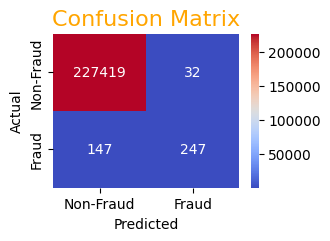


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.58      0.70        98

    accuracy                           1.00     56962
   macro avg       0.93      0.79      0.85     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9991222218320986

ROC AUC Score for Test Set: 0.9762150006316539

Confusion Matrix for Test Set:


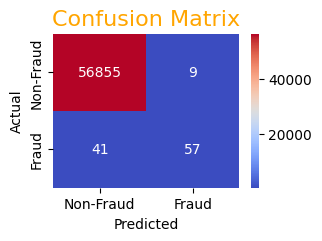

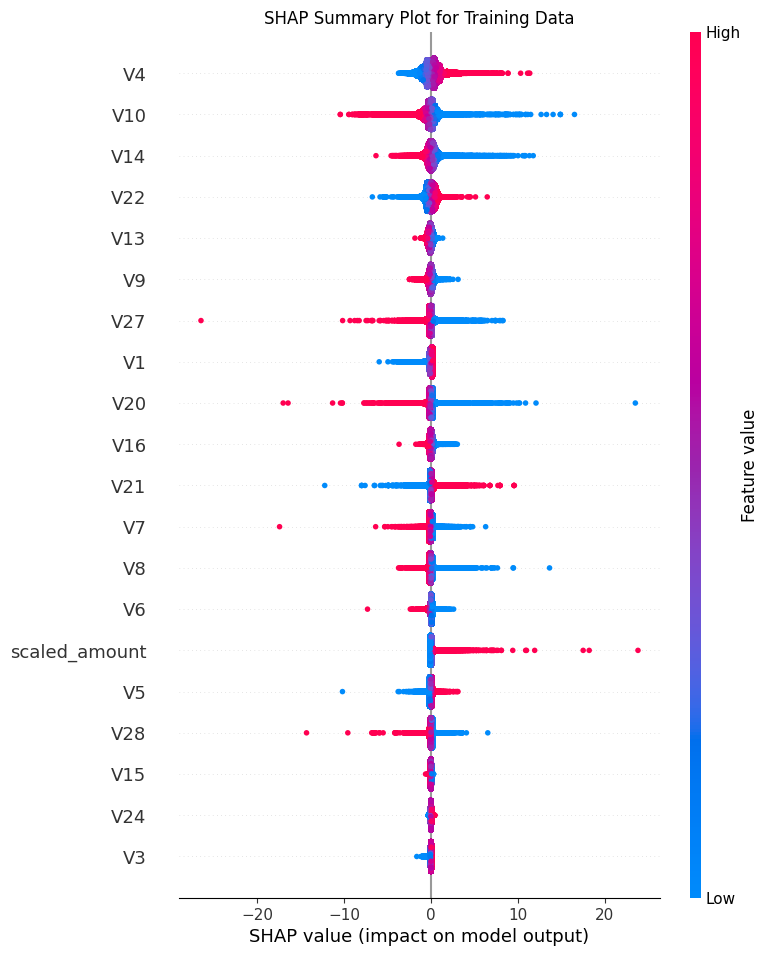

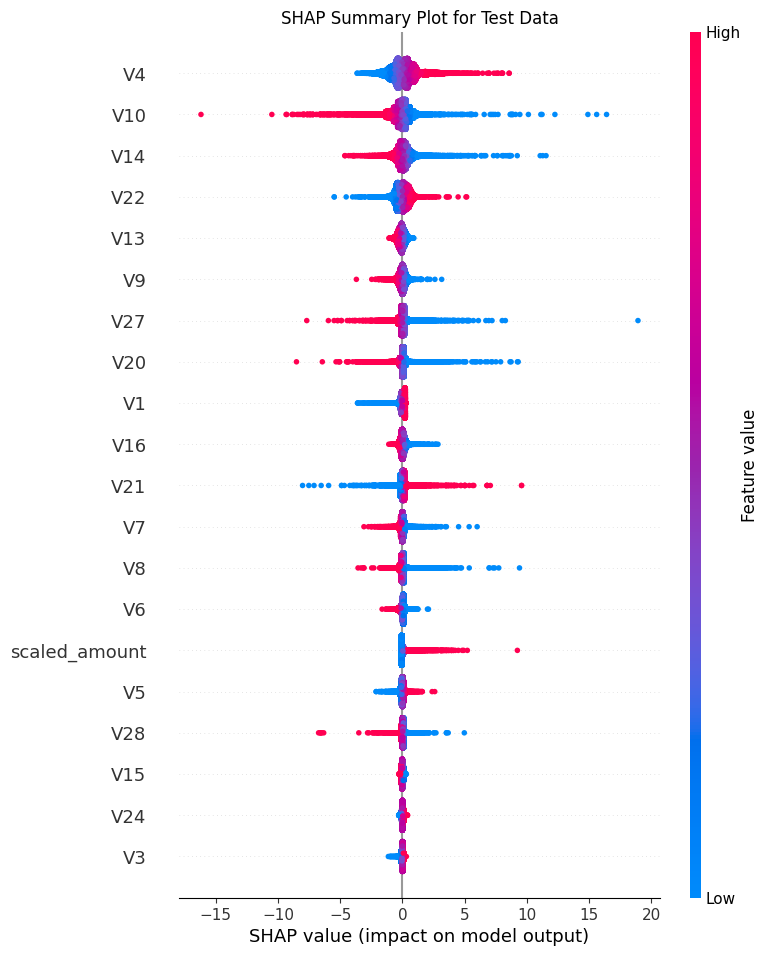

LogisticRegression()

In [39]:
model_classifier('logistic_regression', vars['x_train'], vars['x_test'], vars['y_train'], vars['y_test'])

__Model Performance With Important Features extracted from RandomForest__

Classification Report for Training Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    227451
           1       0.89      0.61      0.72       394

    accuracy                           1.00    227845
   macro avg       0.94      0.80      0.86    227845
weighted avg       1.00      1.00      1.00    227845

Accuracy Score for Training Set: 0.9991836555553117

ROC AUC Score for Training Set: 0.9756783672288473

Confusion Matrix for Training Set:



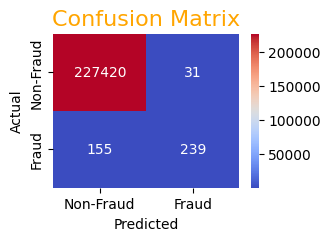


Classification Report for Test Set:

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.85      0.57      0.68        98

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962

Accuracy Score for Test Set: 0.9990871107053826

ROC AUC Score for Test Set: 0.9720276018398355

Confusion Matrix for Test Set:


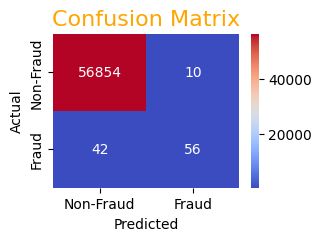

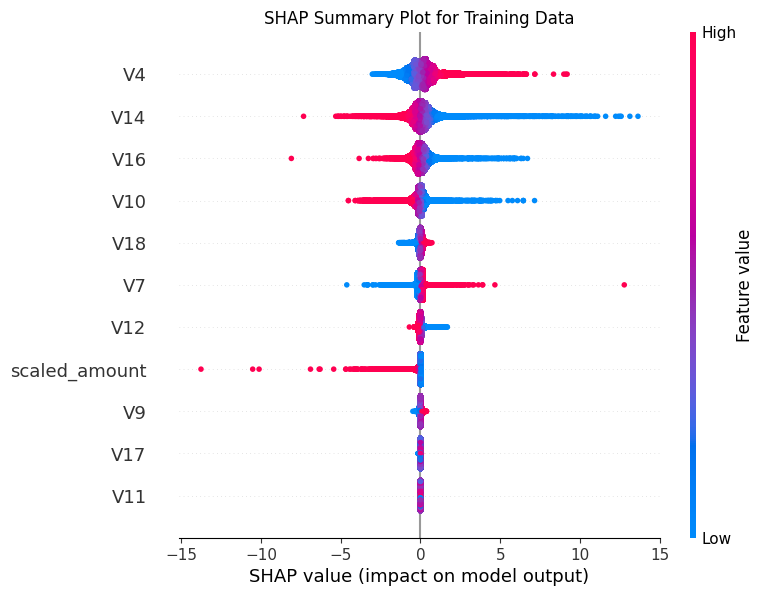

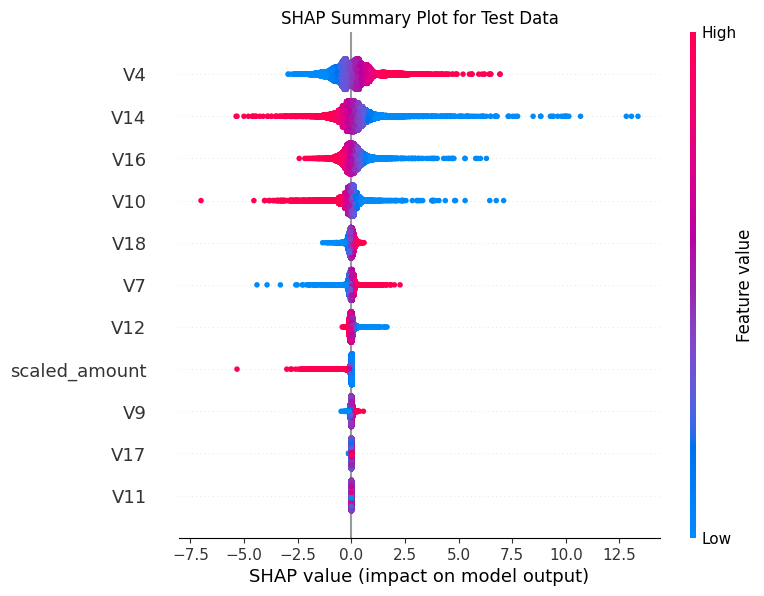

LogisticRegression()

In [10]:
model_classifier('logistic_regression', vars['x_train_impFeatures'], vars['x_test_impFeatures'], vars['y_train'], vars['y_test'])